# BigMart Sales Forecast

Forecasting BigMart Sales.
Data gotten from Kaggle -https://www.kaggle.com/brijbhushannanda1979/bigmart-sales-data

# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score,mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from xgboost import XGBRegressor


# Data Import and Preprocessing

In [2]:
big_mart_data = pd.read_csv("train.csv")

In [3]:
big_mart_data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [4]:
big_mart_data.shape

(8523, 12)

In [5]:
big_mart_data.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


In [6]:
big_mart_data.isnull().sum().sort_values(ascending=False)

Outlet_Size                  2410
Item_Weight                  1463
Item_Identifier                 0
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Item_Weight', ylabel='Density'>

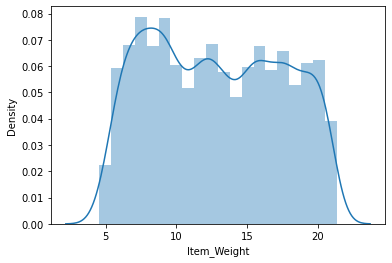

In [7]:
sns.distplot(big_mart_data["Item_Weight"])

In [8]:
big_mart_data["Item_Weight"] = big_mart_data["Item_Weight"].fillna(big_mart_data["Item_Weight"].mean())

In [9]:
# filling the missing values in "Outlet_Size" column with Mode
mode_of_Outlet_size = big_mart_data.pivot_table(values='Outlet_Size', columns='Outlet_Type', aggfunc=(lambda x: x.mode()[0]))

In [10]:
print(mode_of_Outlet_size)

Outlet_Type Grocery Store Supermarket Type1 Supermarket Type2  \
Outlet_Size         Small             Small            Medium   

Outlet_Type Supermarket Type3  
Outlet_Size            Medium  


In [11]:
miss_values = big_mart_data['Outlet_Size'].isnull()   

In [12]:
big_mart_data.loc[miss_values, 'Outlet_Size'] = big_mart_data.loc[miss_values,'Outlet_Type'].apply(lambda x: mode_of_Outlet_size[x])

In [13]:
big_mart_data.isnull().sum().sort_values(ascending=False)

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

# Data Analysis

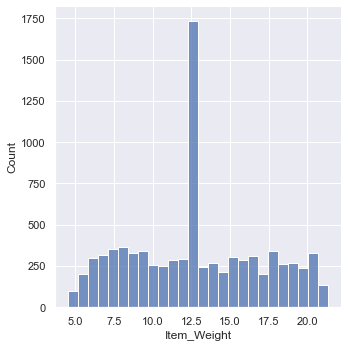

In [14]:
sns.set()
sns.displot(big_mart_data["Item_Weight"])

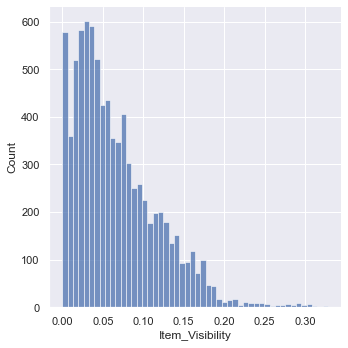

In [15]:
sns.set()
sns.displot(big_mart_data["Item_Visibility"])

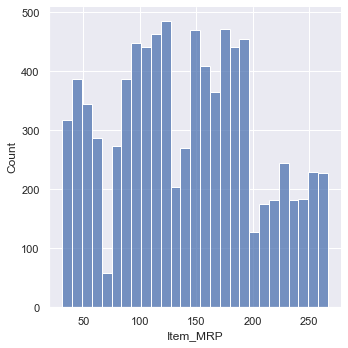

In [16]:
sns.set()
sns.displot(big_mart_data["Item_MRP"])

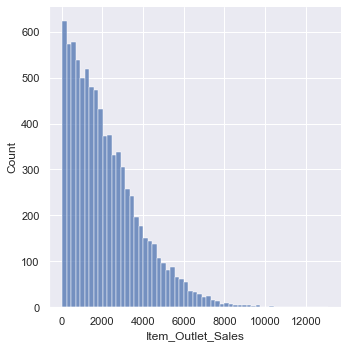

In [17]:
sns.set()
sns.displot(big_mart_data["Item_Outlet_Sales"])

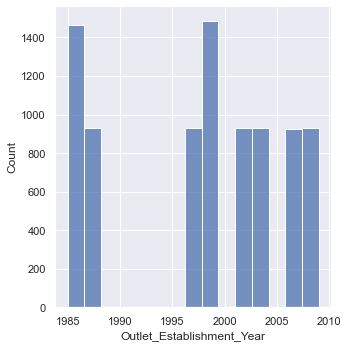

In [18]:
sns.set()
sns.displot(big_mart_data["Outlet_Establishment_Year"])

<AxesSubplot:xlabel='Outlet_Establishment_Year', ylabel='count'>

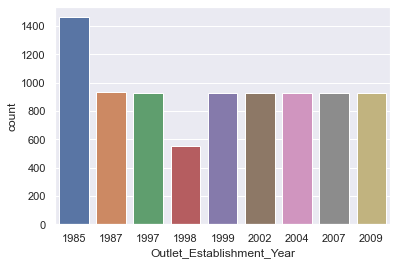

In [19]:
sns.set()
sns.countplot(x = "Outlet_Establishment_Year", data=big_mart_data)

<AxesSubplot:xlabel='Item_Type', ylabel='count'>

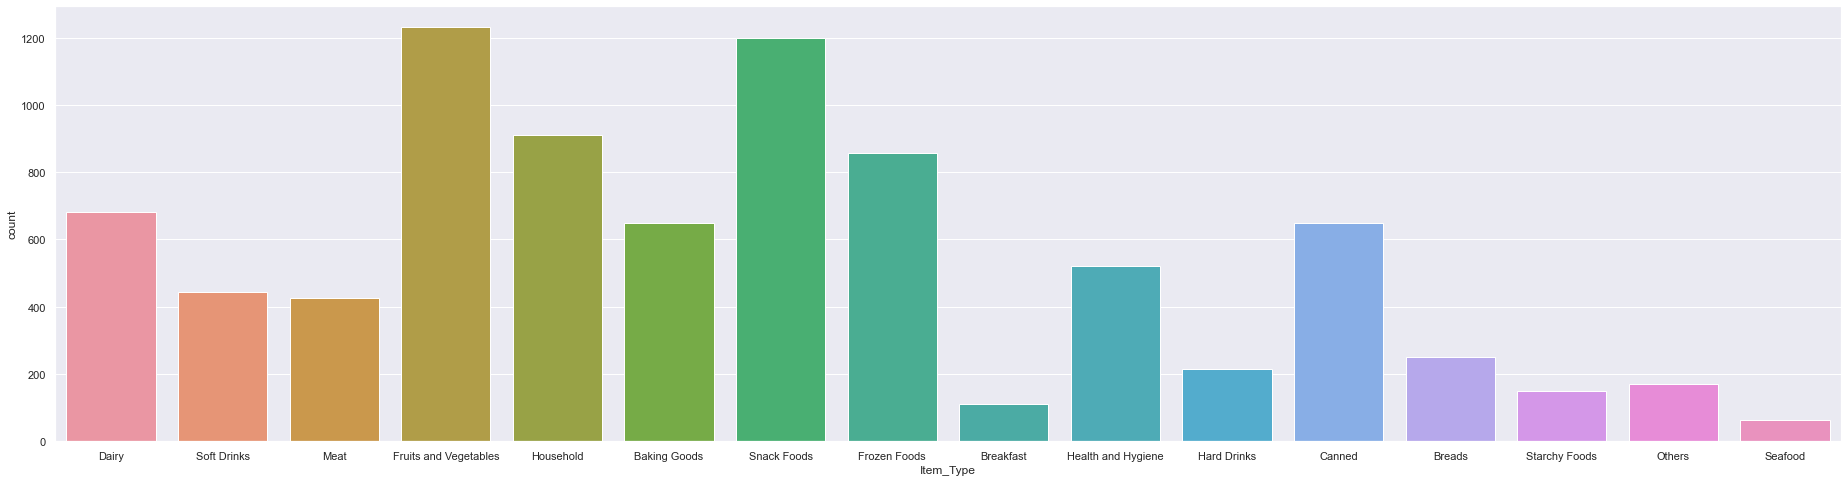

In [20]:
plt.figure(figsize = (32,8))
sns.set()
sns.countplot(x = "Item_Type", data=big_mart_data)

# Label Encoding & Train Test Split

In [21]:
big_mart_data["Item_Fat_Content"].value_counts()

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

In [22]:
big_mart_data.replace({"Item_Fat_Content": {"Low Fat": "Low Fat", "LF": "Low Fat", "low fat": "Low Fat", "reg": "Regular"}}, inplace=True)

In [23]:
big_mart_data["Item_Fat_Content"].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

In [24]:
encoder = LabelEncoder()

In [25]:
big_mart_data.columns

Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type', 'Item_Outlet_Sales'],
      dtype='object')

In [26]:
big_mart_data["Item_Identifier"] = encoder.fit_transform(big_mart_data["Item_Identifier"])
big_mart_data["Item_Fat_Content"] = encoder.fit_transform(big_mart_data["Item_Fat_Content"])
big_mart_data["Item_Type"] = encoder.fit_transform(big_mart_data["Item_Type"])
big_mart_data["Outlet_Identifier"] = encoder.fit_transform(big_mart_data["Outlet_Identifier"])
big_mart_data["Outlet_Size"] = encoder.fit_transform(big_mart_data["Outlet_Size"])
big_mart_data["Outlet_Location_Type"] = encoder.fit_transform(big_mart_data["Outlet_Location_Type"])
big_mart_data["Outlet_Type"] = encoder.fit_transform(big_mart_data["Outlet_Type"])



In [27]:
big_mart_data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,156,9.30,0,0.016047,4,249.8092,9,1999,1,0,1,3735.1380
1,8,5.92,1,0.019278,14,48.2692,3,2009,1,2,2,443.4228
2,662,17.50,0,0.016760,10,141.6180,9,1999,1,0,1,2097.2700
3,1121,19.20,1,0.000000,6,182.0950,0,1998,2,2,0,732.3800
4,1297,8.93,0,0.000000,9,53.8614,1,1987,0,2,1,994.7052


In [28]:
X = big_mart_data.drop(columns=["Item_Outlet_Sales"])
Y = big_mart_data["Item_Outlet_Sales"]

In [29]:
print(X)

      Item_Identifier  Item_Weight  Item_Fat_Content  Item_Visibility  \
0                 156        9.300                 0         0.016047   
1                   8        5.920                 1         0.019278   
2                 662       17.500                 0         0.016760   
3                1121       19.200                 1         0.000000   
4                1297        8.930                 0         0.000000   
...               ...          ...               ...              ...   
8518              370        6.865                 0         0.056783   
8519              897        8.380                 1         0.046982   
8520             1357       10.600                 0         0.035186   
8521              681        7.210                 1         0.145221   
8522               50       14.800                 0         0.044878   

      Item_Type  Item_MRP  Outlet_Identifier  Outlet_Establishment_Year  \
0             4  249.8092                  9    

In [30]:
print(Y)

0       3735.1380
1        443.4228
2       2097.2700
3        732.3800
4        994.7052
          ...    
8518    2778.3834
8519     549.2850
8520    1193.1136
8521    1845.5976
8522     765.6700
Name: Item_Outlet_Sales, Length: 8523, dtype: float64


In [31]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=45)

In [32]:
print(X.shape, X_train.shape, X_test.shape)

(8523, 11) (6818, 11) (1705, 11)


# Model Selection and Training

In [33]:
xg_regressor = XGBRegressor()

In [34]:
xg_regressor.fit(X_train, Y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [35]:
#evaluate on training data maybe
y_train_predicted = xg_regressor.predict(X_train)
y_train_predicted

array([3856.0728  , 1562.47    , 1375.3999  , ...,  768.03284 ,
        820.77466 ,   66.278366], dtype=float32)

In [36]:
#accuracy on training data
train_score = xg_regressor.score(X_train, Y_train)
train_score

0.8637166380168253

In [37]:
#r2 error on training data
train_r2_error = r2_score(y_train_predicted, Y_train)
train_r2_error

0.8130050142505187

# Model Evaluation on Test Data

In [38]:
#evaluate on training data maybe
y_test_predicted = xg_regressor.predict(X_test)
y_test_predicted

array([4891.995 , 1330.3574,  677.8902, ..., 2452.7144, 1399.6531,
       3227.8113], dtype=float32)

In [39]:
#accuracy on training data
test_score = xg_regressor.score(X_test, Y_test)
test_score

0.527484794481089

In [40]:
#r2 error on training data
test_r2_error = r2_score(y_test_predicted, Y_test)
test_r2_error

0.32183713939532943

# Predicted and Actual Data Visualisation

Text(0.5, 0, 'Values')

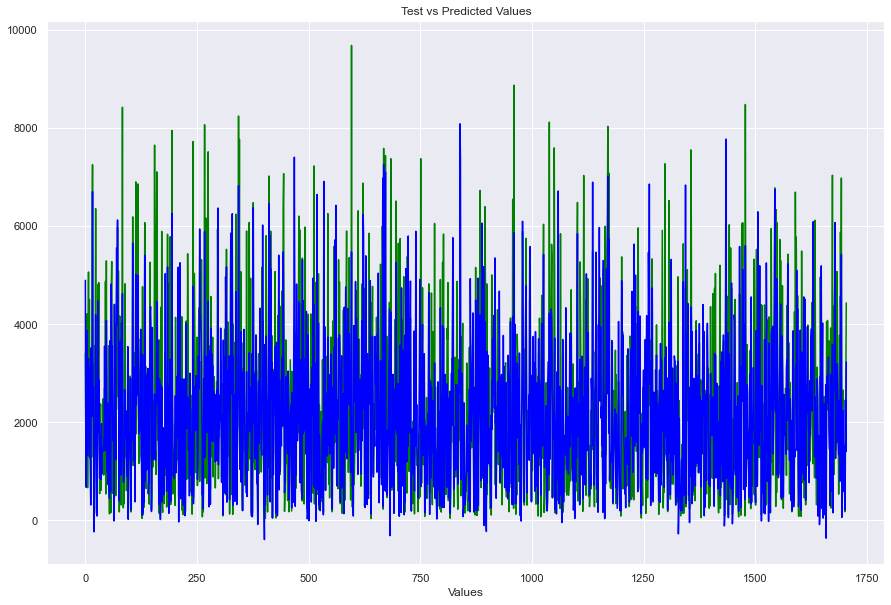

In [41]:
plt.figure(figsize =(15,10))
Y_test = list(Y_test)
plt.plot(Y_test, label="Test Data", color="green")
plt.plot(y_test_predicted, label="Predicted Data", color="blue")
plt.title("Test vs Predicted Values")
plt.xlabel("Values")

I'll be back to improve the accuracy of this model